## Imports

In [3]:
%%time

# Data Manipulation
import pandas as pd
pd.set_option('use_inf_as_na', True)
import numpy as np
from sklearn.model_selection import train_test_split

# tweets processing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords

# Visual modules
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


# Converting words to numbers (bags of words)
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

# Algorithms
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier


# Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Save model
import joblib

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bless\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bless\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Wall time: 5.51 s


In [4]:
#CONSTANTS
TWITTER_LOGO = 'utils/Twitter logo 2012.png'
EXTRA_WORDS = 'utils/extra_words.txt'
TRAIN_FILE = 'data/train.csv'
SUB_FILE = 'data/test.csv'
FONT_PATH = r'gatsby\GatsbyFLF-bold.ttf'

MODEL_FILE = 'some-model'


In [5]:
#Load data and extract inputs and outputs
data_df = pd.read_csv(r'.\Data\train.csv').set_index('id')[:1000]

texts = data_df.drop(['target'], axis = 1)
#tweets = texts.text
y = data_df.target

In [6]:
texts.head()

,keyword,location,text
id,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
4,NaN,NaN,Forest fire near La Ronge Sask. Canada
5,NaN,NaN,All residents asked to 'shelter in place' are ...
6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...


In [7]:
data_df.sample(frac=1).head()

,keyword,location,text,target
id,,,,
818,battle,Wisconsin,@SexyDragonMagic I've come to the realization ...,0
1380,body%20bag,New York,New Ladies Shoulder Tote Handbag Women Cross B...,0
109,accident,NaN,RT @SleepJunkies: Sleeping pills double your r...,0
247,ambulance,Jackson,http://t.co/AY6zzcUpnz Twelve feared killed in...,1
1278,blood,"Brecksville, OH",Add these items to your everyday eating habits...,0


In [8]:
full_text = texts.keyword.fillna(' ')+' '+texts.location.fillna(' ') +' '+texts.text.fillna(' ')


In [9]:
full_text.tail()

id
1445    body%20bagging   Body Bagging Bitches ???? htt...
1447    body%20bagging PURPLE BOOTH STUDIOã¢ No bette...
1448    body%20bagging Cloud 9 Mopheme and Bigstar Joh...
1449    body%20bagging   I was body Bagging on the ???...
1450    body%20bagging Former Yugoslav Republic of Mac...
dtype: object

In [11]:
def ProcessTweet(tweet):
    extra_words = (pd.read_table(EXTRA_WORDS, header = None))[0].values.tolist()
    _stopwords = set(stopwords.words('english') + list(punctuation) +
                     ['AT_USER','URL'] + extra_words)
    
    tweet = tweet.lower() # convert tweets to lower-case
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet) # remove URLs
    tweet = re.sub('@[^\s]+', 'AT_USER', tweet) # remove usernames
    tweet =  re.sub(r'#([^\s]+)', r'\1', tweet) # remove the # in #hashtag
    tweet =  word_tokenize(tweet) # remove repeated characters (helloooooooo into hello)
    
    return [word for word in tweet if word not in _stopwords]

In [12]:
def Process_df(full_text_df):
    tokened_text = full_text_df.apply(ProcessTweet)
    words = [word for item in tokened_text for word in item]
    cleaned_text_df = tokened_text.apply(' '.join)
    
    vectorizer = CountVectorizer(max_features = 3000, min_df = 5, max_df = 0.7)
    text_array = vectorizer.fit_transform(cleaned_text_df).toarray()
    
    
    return words, text_array

In [10]:
def make_cloud(word_tokens, image_file_path, font_path = None):
    
    """
    makes a word cloud from tokens, using the image in 
    image_file_path for a mask
    
    
    
    """
    
    word_str = ' '.join(word_tokens)
    
    mask = Image.open(image_file_path)
    img_mask = Image.new(mode='RGB', size=mask.size, color = (255,255,255))
    img_mask.paste(mask, box = mask)
    
    rgb_array = np.array(img_mask)
    

    cloud = WordCloud(font_path=font_path,
                  mask=rgb_array,background_color='black',
                  max_words=600, colormap = 'Set3')

    cloud.generate(word_str.upper())
    plt.figure(figsize=(15,10))
    plt.axis('off')
    plt.imshow(cloud, interpolation='bilinear')

Wall time: 9.36 s


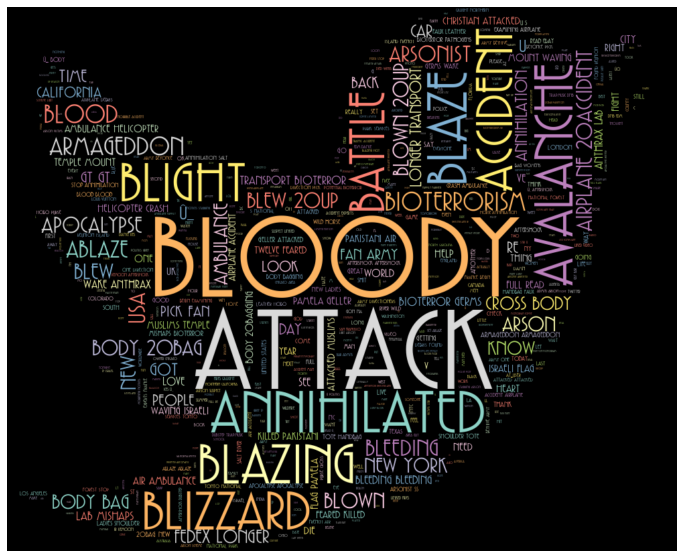

In [14]:
%%time
#Clean text and extract words
words, train_array = Process_df(full_text)

# Make wordcloud
make_cloud(words, TWITTER_LOGO, font_path=FONT_PATH)

In [13]:
def get_models():
    
    models = {'Gaussian NB': GaussianNB(),
              'SVC': LinearSVC(max_iter = 1000),
              'LR': LogisticRegression(C = 0.6),
              'RF': RandomForestClassifier(n_estimators = 200), 
              'SVC calibrated':CalibratedClassifierCV((LinearSVC(max_iter = 10000)), cv = 2, method = 'sigmoid'),
              'LR calibrated': CalibratedClassifierCV(LogisticRegression(), method = 'sigmoid',cv = 2)
             }
    
    return models

In [15]:
def scores_list_to_df(scores):
    """
    Takes a list and turns it into a sorted dataframe through a dict
    in an intermediate step.
    
    Args:
        scores: List of scores with models attributed to them

    Returns:
        A dataframe sorted by accuracy with 2 different bagging shemes
    
    """
    score_dict= dict((key,d[key]) for d in scores for key in d)
    score_df = pd.DataFrame.from_dict(score_dict,
                                      orient='index', columns=['vec_accuracy', 'tfid_accuracy', 'pca_accuracy'])
    
    return score_df.sort_values(by=['vec_accuracy', 'tfid_accuracy', 'pca_accuracy'], ascending = False)

Gaussian NB
Accuracy with vectorizer for Gaussian NB = 35.7%
Accuracy with tifd converter for Gaussian NB = 37.7%
Accuracy with pca for Gaussian NB = 62.8%


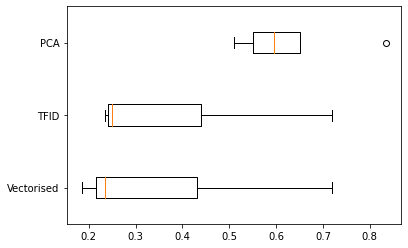




SVC
Accuracy with vectorizer for SVC = 39.4%
Accuracy with tifd converter for SVC = 40.1%
Accuracy with pca for SVC = 63.8%


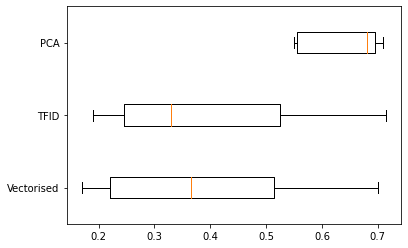




LR
Accuracy with vectorizer for LR = 40.0%
Accuracy with tifd converter for LR = 57.3%
Accuracy with pca for LR = 64.3%


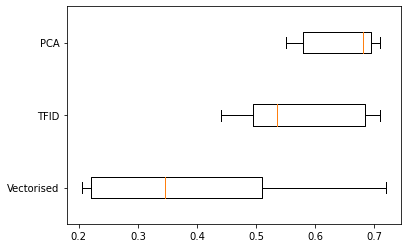




RF
Accuracy with vectorizer for RF = 39.0%
Accuracy with tifd converter for RF = 36.0%
Accuracy with pca for RF = 50.2%


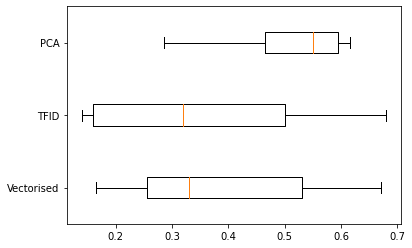




SVC calibrated
Accuracy with vectorizer for SVC calibrated = 69.5%
Accuracy with tifd converter for SVC calibrated = 70.4%
Accuracy with pca for SVC calibrated = 63.1%


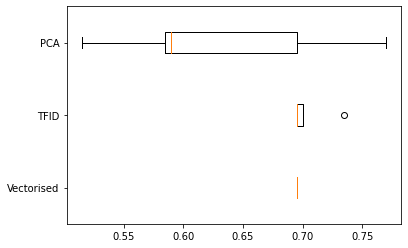




LR calibrated
Accuracy with vectorizer for LR calibrated = 71.5%
Accuracy with tifd converter for LR calibrated = 71.1%
Accuracy with pca for LR calibrated = 69.6%


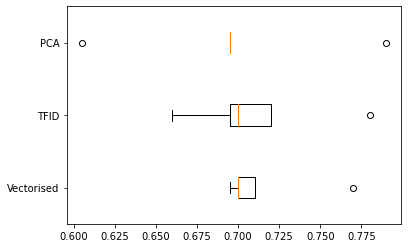




Wall time: 15.2 s


In [16]:
%%time
models = get_models()

converter = TfidfTransformer()
Tfid_train_array = converter.fit_transform(train_array).toarray()

pca = PCA(n_components = 10, svd_solver='full')
pca_train_array = pca.fit_transform(train_array)

cv_scores = []

scores = []
for model in models:
    clf = models[model]
    
    vec_scores = cross_val_score(clf,train_array, y, cv = 5)
    mean_vec_score = np.mean(vec_scores)
    
    tfid_scores = cross_val_score(clf, Tfid_train_array, y, cv = 5)
    mean_tfid_score = np.mean(tfid_scores)
    
    pca_scores = cross_val_score(clf, pca_train_array, y, cv = 5)
    mean_pca_score = np.mean(pca_scores) 
    
    print(model)
    print(f"Accuracy with vectorizer for {model} = {mean_vec_score:.1%}")
    print(f"Accuracy with tifd converter for {model} = {mean_tfid_score:.1%}")
    print(f"Accuracy with pca for {model} = {mean_pca_score:.1%}")
    
    _ = plt.boxplot([vec_scores, tfid_scores, pca_scores], vert=False)
    plt.yticks([1,2,3], ['Vectorised', 'TFID', 'PCA'])
    plt.show()
    print("\n"*2)
    
    score = {model:[mean_vec_score, mean_tfid_score, mean_pca_score]}
    scores.append(score)

In [17]:
model_scores_df = scores_list_to_df(scores)
model_scores_df

,vec_accuracy,tfid_accuracy,pca_accuracy
LR calibrated,0.715,0.711,0.696
SVC calibrated,0.695,0.704,0.631
LR,0.400,0.573,0.643
SVC,0.394,0.401,0.638
RF,0.390,0.360,0.502
Gaussian NB,0.357,0.377,0.628


In [61]:
from sklearn.model_selection import GridSearchCV

parameters = {'base_estimator__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'base_estimator__C':np.linspace(0.02,0.08,20),
              'base_estimator__warm_start': [True, False]
             }

clf = GridSearchCV(models['LR calibrated'], parameters, verbose=0)
clf.fit(train_array, y)



GridSearchCV(estimator=CalibratedClassifierCV(base_estimator=LogisticRegression(),
                                              cv=2),
             param_grid={'base_estimator__C': array([0.02      , 0.02315789, 0.02631579, 0.02947368, 0.03263158,
       0.03578947, 0.03894737, 0.04210526, 0.04526316, 0.04842105,
       0.05157895, 0.05473684, 0.05789474, 0.06105263, 0.06421053,
       0.06736842, 0.07052632, 0.07368421, 0.07684211, 0.08      ]),
                         'base_estimator__solver': ['newton-cg', 'lbfgs',
                                                    'liblinear', 'sag',
                                                    'saga'],
                         'base_estimator__warm_start': [True, False]})

In [62]:
print(clf.best_score_)
print(clf.best_params_)

0.7299999999999999
{'base_estimator__C': 0.07052631578947369, 'base_estimator__solver': 'newton-cg', 'base_estimator__warm_start': True}


In [63]:
filename = 'finalized_model.sav'
joblib.dump(clf.best_estimator_, filename)

['finalized_model.sav']

# Generate predictions

In [64]:
test = pd.read_csv(r".\Data\test.csv").set_index('id')

In [65]:
test_text = test.keyword.fillna(' ')+' '+test.location.fillna(' ') +' '+test.text.fillna(' ')

Wall time: 17.7 s


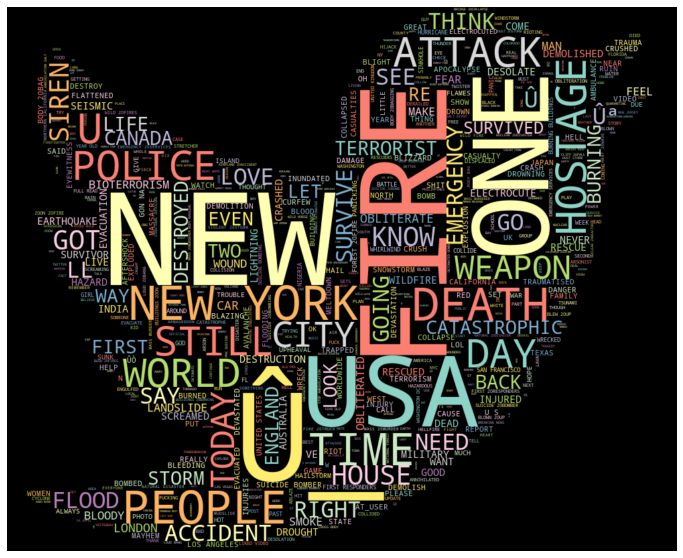

In [66]:
%%time
#Clean text and extract words
test_words, test_array = Process_df(test_text)

#Make wordcloud
make_cloud(test_words, TWITTER_LOGO)

In [73]:
loaded_model = joblib.load(filename)